In [1]:
!git clone https://github.com/AndreyK2001/BERT-Classification

Cloning into 'BERT-Classification'...
remote: Enumerating objects: 140, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 140 (delta 11), reused 33 (delta 8), pack-reused 103
Receiving objects: 100% (140/140), 46.69 MiB | 21.73 MiB/s, done.
Resolving deltas: 100% (46/46), done.


In [2]:
import os

os.system("""wget "https://getfile.dokpub.com/yandex/get/https://disk.yandex.com/d/7bfAPhxzUXl5vw" -O VvsW_en""")

0

In [3]:
import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from transformers import BertForSequenceClassification
import pandas as pd
import numpy as np

In [5]:
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}

    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        tqdm.write(f'Class: {label_dict_inverse[label]}')
        tqdm.write(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

def plot_confusion_matrix(preds, labels, label_dict):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    label_to_name = {value: key for key, value in label_dict.items()}

    # Вычисляем confusion matrix
    cm = confusion_matrix(labels_flat, preds_flat)
    label_names = list(label_dict.keys()) #['Easy', 'Normal']
    #label_names = ['Very Easy', 'Easy', 'Normal', 'Hard', 'Very Hard']#[label_to_name.get(label, "Unknown") for label in np.unique(labels_flat)]

    # Визуализация confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm[::-1], annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names[::-1])
    plt.title('Confusion Matrix')
    plt.ylabel('Истинные классы')
    plt.xlabel('Предсказанные классы')
    plt.show()


def metrics_per_class(preds, labels, label_dict):
    label_dict_inverse = {v: k for k, v in label_dict.items()}

    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    # Calculate confusion matrix
    cm = confusion_matrix(labels_flat, preds_flat)

    for label in np.unique(labels_flat):
        # True Positives
        TP = cm[label, label]
        # False Positives: sum of the corresponding column minus TP
        FP = np.sum(cm[:, label]) - TP
        # False Negatives: sum of the corresponding row minus TP
        FN = np.sum(cm[label, :]) - TP

        precision = TP / (TP + FP) if (TP + FP) != 0 else 0
        recall = TP / (TP + FN) if (TP + FN) != 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

        tqdm.write(f'Class: {label_dict_inverse[label]}')
        tqdm.write(f'Accuracy: {TP}/{TP+FN} (True Positives / Total Actual Positives)')
        tqdm.write(f'Precision: {precision:.2f}')
        tqdm.write(f'Recall: {recall:.2f}')
        tqdm.write(f'F1 Score: {f1:.2f}\n')

In [7]:
def evaluate(dataloader_val):

    model.eval()

    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in dataloader_val:

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    loss_val_avg = loss_val_total/len(dataloader_val)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals

In [8]:
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased",
                                                      num_labels=2,
                                                      output_attentions=False,
                                                      output_hidden_states=True)

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
stete_dict = torch.load("./VvsW_en", map_location='cpu')
model.load_state_dict(stete_dict)

device = "cpu"
if torch.cuda.is_available(): device = "cuda"

model = model.to(device)

In [11]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased',
                                          do_lower_case=True)

Languages:   0%|          | 0/4 [00:00<?, ?it/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2619: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


es
Predictions loss: 2.665273862216124
F1 Score (Weighted): 0.676870348148671


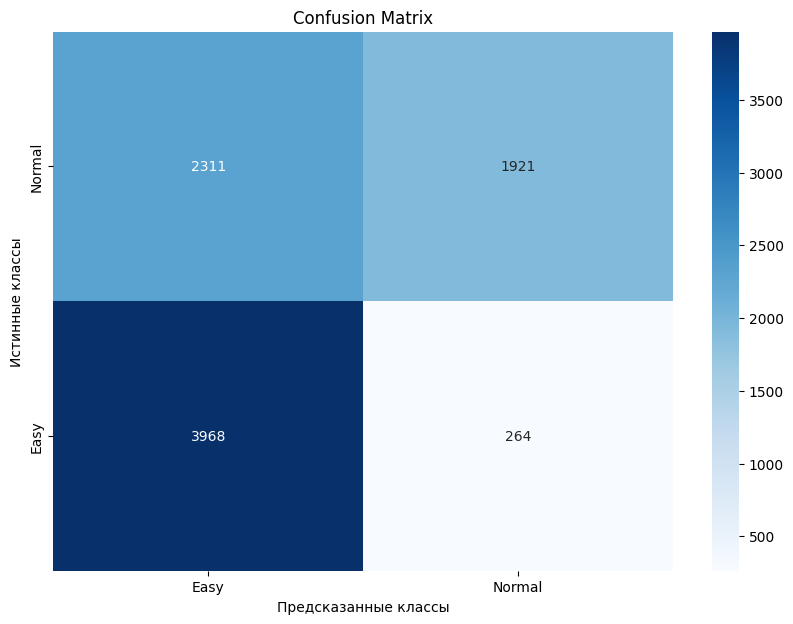

Class: Easy
Accuracy: 3968/4232 (True Positives / Total Actual Positives)
Precision: 0.63
Recall: 0.94
F1 Score: 0.76

Class: Normal
Accuracy: 1921/4232 (True Positives / Total Actual Positives)
Precision: 0.88
Recall: 0.45
F1 Score: 0.60



Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2619: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


it
Predictions loss: 0.5343495486260673
F1 Score (Weighted): 0.9252239648741378


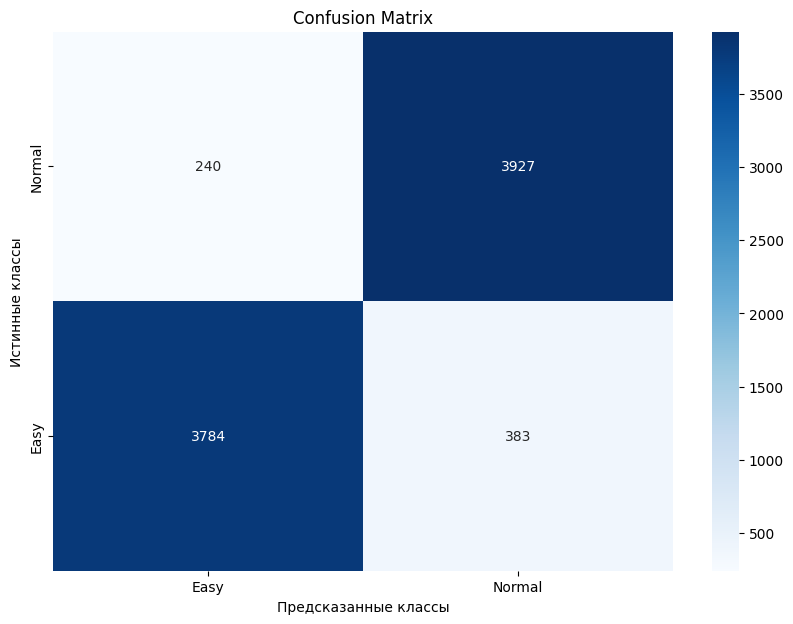

Class: Easy
Accuracy: 3784/4167 (True Positives / Total Actual Positives)
Precision: 0.94
Recall: 0.91
F1 Score: 0.92

Class: Normal
Accuracy: 3927/4167 (True Positives / Total Actual Positives)
Precision: 0.91
Recall: 0.94
F1 Score: 0.93



Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2619: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


ru
Predictions loss: 0.3102467060394806
F1 Score (Weighted): 0.9518518518518518


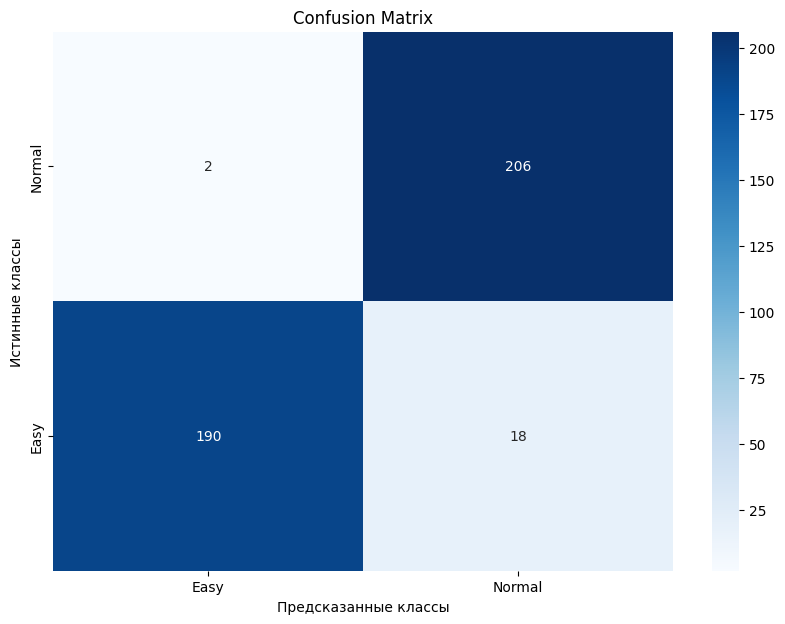

Class: Easy
Accuracy: 190/208 (True Positives / Total Actual Positives)
Precision: 0.99
Recall: 0.91
F1 Score: 0.95

Class: Normal
Accuracy: 206/208 (True Positives / Total Actual Positives)
Precision: 0.92
Recall: 0.99
F1 Score: 0.95



Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2619: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


fr
Predictions loss: 0.5590308185596168
F1 Score (Weighted): 0.9267694049915968


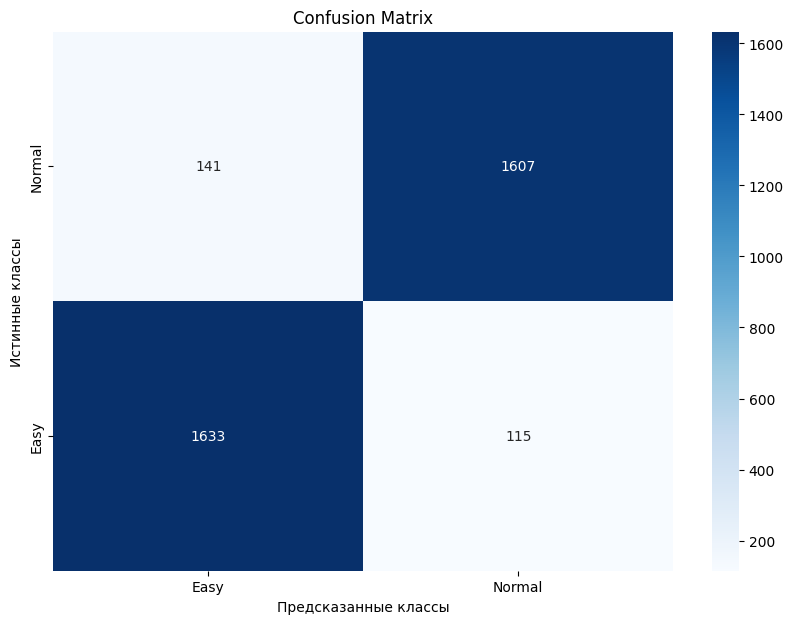

Class: Easy
Accuracy: 1633/1748 (True Positives / Total Actual Positives)
Precision: 0.92
Recall: 0.93
F1 Score: 0.93

Class: Normal
Accuracy: 1607/1748 (True Positives / Total Actual Positives)
Precision: 0.93
Recall: 0.92
F1 Score: 0.93



In [12]:
for language in tqdm(['es', 'it', 'ru', 'fr'], desc="Languages"):

    label_dict = {'Easy': 0, 'Normal': 1}
    df = pd.read_csv(f'/content/BERT-Classification/2 class wiki/wikidatasests/dataset_{language}.csv', sep=';').dropna()

    Vikidia_texts = pd.DataFrame({'text': df['Vikidia'].values, 'label': 0})
    Wikipedia_texts = pd.DataFrame({'text': df['Wikipedia'].values, 'label': 1})
    df = pd.concat([Vikidia_texts, Wikipedia_texts], ignore_index=True)

    tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased',
                                          do_lower_case=True)

    encoded_data_predict = tokenizer.batch_encode_plus(
        df.text.values,
        add_special_tokens=True,
        return_attention_mask=True,
        pad_to_max_length=True,
        max_length=256,
        return_tensors='pt'
    )

    input_ids_predict = encoded_data_predict['input_ids']
    attention_masks_predict = encoded_data_predict['attention_mask']
    labels_predict = torch.tensor(df.label.values)

    dataset_predict = TensorDataset(input_ids_predict, attention_masks_predict, labels_predict)


    batch_size = 3

    dataloader_predict = DataLoader(dataset_predict,
                                  sampler=SequentialSampler(dataset_predict),
                                  batch_size=batch_size)

    predict_loss, predictions, true_predict = evaluate(dataloader_predict)
    predict_f1 = f1_score_func(predictions, true_predict)

    print(language)
    print(f'Predictions loss: {predict_loss}')
    print(f'F1 Score (Weighted): {predict_f1}')
    plot_confusion_matrix(predictions, true_predict, label_dict)
    metrics_per_class(predictions, true_predict, label_dict)